In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
import pymorphy2
from tqdm import tqdm

from gensim.models import LdaModel, CoherenceModel
from gensim import corpora

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)

negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)

df = pd.concat([positive, negative])

In [4]:
df.head(4)

,text,label
0,"@first_timee хоть я и школота, но поверь, у на...",positive
1,"Да, все-таки он немного похож на него. Но мой ...",positive
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,positive
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",positive


In [5]:
morph = pymorphy2.MorphAnalyzer()
words_regex = re.compile('\w+')
stopwords_list = stopwords.words('russian')

In [6]:
def find_words(text, regex=words_regex):
    tokens = regex.findall(text.lower())
    
    return [w for w in tokens if w.isalpha() and len(w) >= 3]

def lemmatize(words, lemmer=morph, stopwords=stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    
    return [w for w in lemmas if not w in stopwords and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

Посмотрим на первый твит, после чего применим функцию для лемматизации:

In [7]:
df.text.iloc[0]

'@first_timee хоть я и школота, но поверь, у нас то же самое :D общество профилирующий предмет типа)'

In [8]:
print(preprocess(df.text.iloc[0]))

['школотый', 'поверь', 'самый', 'общество', 'профилировать', 'предмет', 'тип']


Применим ко всему датасету:

In [9]:
preprocessed_text = list(map(preprocess, df['text']))

In [10]:
df['text'] = preprocessed_text
df.sample(4)

,text,label
6677,"[двигать, вокзал, менее, час, поезд, хотеться,...",negative
86433,"[обида, сказать, знать, почему]",positive
25513,"[дибил, критично, тупой, ответ]",negative
82610,"[заболеть, ждать, дом, лечить]",negative


Создадим словарь и векторизуем документы:

In [11]:
dictionary = corpora.Dictionary(df['text'])

dictionary.filter_extremes(no_below=10, no_above=0.9, keep_n=None)
dictionary.save('tweet.dict')

In [12]:
corpus = [dictionary.doc2bow(text) for text in df['text']]

corpora.MmCorpus.serialize('tweet.model', corpus)

Обучим модель (при помощи LDA):

In [13]:
%%time

lda = LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

CPU times: total: 3min 37s
Wall time: 3min 37s


In [14]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(8,
  '0.407*"весь" + 0.179*"писать" + 0.145*"сидеть" + 0.134*"хотеться" + 0.039*"взять" + 0.029*"страшно" + 0.024*"ахах" + 0.017*"всякий" + 0.000*"спать" + 0.000*"дом"'),
 (18,
  '0.223*"который" + 0.212*"время" + 0.135*"работа" + 0.111*"пиздец" + 0.060*"прям" + 0.056*"история" + 0.044*"русский" + 0.035*"хуйня" + 0.035*"свет" + 0.022*"зря"'),
 (6,
  '0.306*"человек" + 0.211*"хороший" + 0.095*"нравиться" + 0.093*"фильм" + 0.057*"получаться" + 0.053*"сериал" + 0.052*"книга" + 0.047*"слушать" + 0.021*"кофе" + 0.015*"мужчина"'),
 (15,
  '0.122*"поддержка" + 0.000*"твой" + 0.000*"хватать" + 0.000*"скучать" + 0.000*"выступать" + 0.000*"читать" + 0.000*"комментарий" + 0.000*"возле" + 0.000*"судья" + 0.000*"глаз"'),
 (17,
  '0.549*"очень" + 0.170*"неделя" + 0.101*"работать" + 0.092*"спасибо" + 0.026*"прекрасный" + 0.021*"главное" + 0.000*"холодно" + 0.000*"скучать" + 0.000*"плохо" + 0.000*"жаль"'),
 (16,
  '0.458*"мочь" + 0.392*"сегодня" + 0.056*"столько" + 0.046*"место" + 0.014*"повод" + 0.

Посмотрим на метрики (перплексия, средняя когерентность):

In [15]:
print(lda.log_perplexity(corpus))

-26.26362821218889


In [16]:
print('Персплексия:', np.exp(lda.log_perplexity(corpus)))

Персплексия: 3.9251042193629e-12


In [17]:
coherence_model_lda = CoherenceModel(model=lda, texts=df['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

print('Средняя когерентность:', coherence_lda)

Средняя когерентность: 0.3301364960384789


Посмотрим визуально на несколько тематик:

In [18]:
def get_topics_words(model, n_topics):
    
    x = model.show_topics(num_topics=n_topics, num_words=10, formatted=False)
    topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

    for topic, words in topics_words:
        print(f"topic_{topic}: " + " ".join(words))

In [19]:
get_topics_words(model=lda, n_topics=4)

topic_5: думать найти серия поэтому группа качать искать the пойти нормальный
topic_15: поддержка твой хватать скучать выступать читать комментарий возле судья глаз
topic_13: блин посмотреть amp фотка значит ощущение часть курить поздний чёрный
topic_8: весь писать сидеть хотеться взять страшно ахах всякий спать дом


Запустим процесс выявления нужного количества тематик для наибольшего значения метрики (по средней когерентности):

In [20]:
ns = (3, 5, 10, 15, 20, 25, 30, 40, 50, 100)
scores = []

for n_topics in tqdm(ns):
    lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, passes=2, random_state=41)
    
    score = CoherenceModel(model=lda, texts=df['text'], dictionary=dictionary).get_coherence()
    scores.append(score)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [11:05<00:00, 66.52s/it]


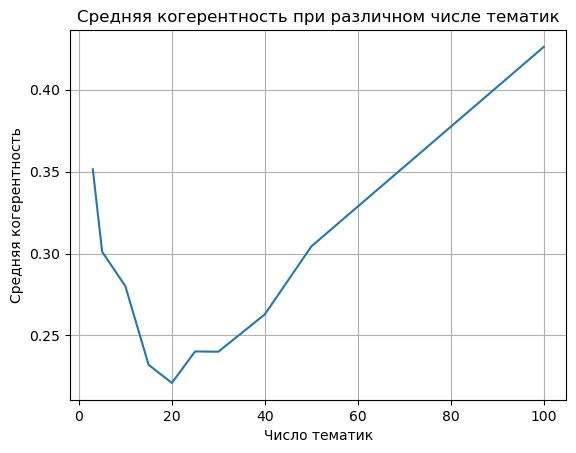

In [21]:
plt.plot(ns, scores)
plt.title('Средняя когерентность при различном числе тематик')
plt.xlabel('Число тематик')
plt.ylabel('Средняя когерентность')
plt.grid()
plt.show()

После стремительного падения у 20 тематик, функция начинает линейно расти, а самое высокое значение средней когерентности наблюдается у 100 тематик. Выберем именно такое количество, обучим модель и посмотрим, что получилось:

In [22]:
final_model = LdaModel(corpus, num_topics=100, id2word=dictionary, passes=2, random_state=41)

In [23]:
get_topics_words(final_model, 100)

topic_0: девушка тви появиться знакомый счастливый редко айфон пожалеть это глава
topic_1: пройти получаться черта хреновый всё это странно попробовать стараться привыкнуть
topic_2: напомнить обидеться заставить настя обижаться колледж круг выход занятие плевать
topic_3: ладный физика встретиться дверь планшет разговор победитель умный сумка авария
topic_4: весь дождь это петь мечтать частый появляться цвет плюс абсолютно
topic_5: снегурочка фикбук обидеть побриться лавочка офигительный одинаково строй смелый mashushnik
topic_6: жизнь любимый твой дело сколько тепло джинсы море отсутствие важно
topic_7: друг сильно начало значит везде дурацкий минус мудак забить подойти
topic_8: болеть работа казаться глаз вспомнить готовый кроме придумать общий форма
topic_9: ночь парень классный милый прекрасный спрашивать лола почитать спокойный это
topic_10: понимать приходить это оставить быстрый всё мнение понятие сушить воспринимать
topic_11: забрать послать фига выпить впереди путь вечный чужой